파일 로드 성공.
데이터 미리보기:
    movieCd     movieNm  audiAcc     salesAcc  targetDt
0  20192567  원더 우먼 1984   548695   4947583400  20210324
1  20202703         뱅가드    29812    250386700  20210113
2  20040725        화양연화   114911   1019244080  20220224
3  20201002          조제   209062   1876179450  20210117
4  20192193          도굴  1544146  13950914410  20210119

데이터 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1243 entries, 0 to 1242
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movieCd   1243 non-null   object
 1   movieNm   1243 non-null   object
 2   audiAcc   1243 non-null   int64 
 3   salesAcc  1243 non-null   int64 
 4   targetDt  1243 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 48.7+ KB

결측치 처리 후 데이터 행 수: 1243

훈련 세트 크기: 994
테스트 세트 크기: 249

랜덤 포레스트 모델 학습 시작...
랜덤 포레스트 모델 학습 완료.
테스트 데이터 예측 시작...
테스트 데이터 예측 완료.

--- 랜덤 포레스트 모델 평가 결과 ---
Mean Squared Error (MSE): 21530036148.39
Root Mean Squared Er

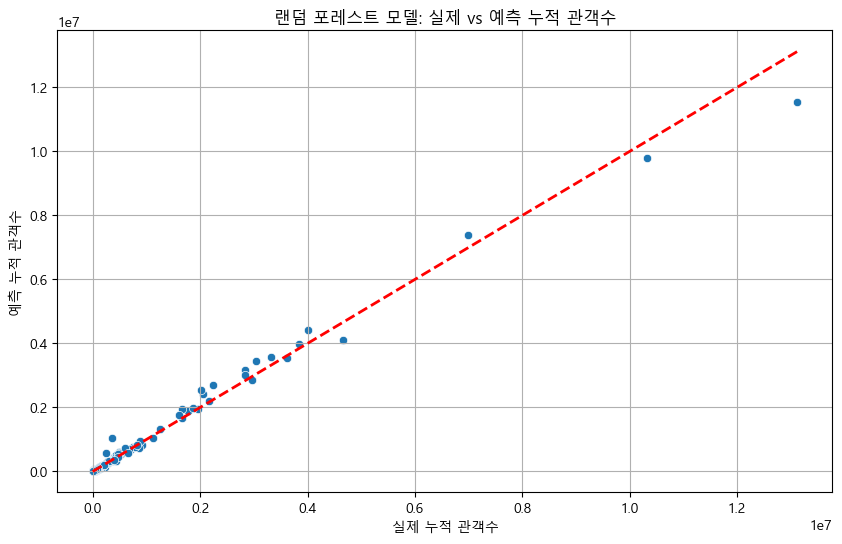


--- 피처 중요도 (Feature Importance) ---
     Feature  Importance
0   salesAcc    0.993262
12   개봉_월_12    0.002264
11   개봉_월_11    0.000935
8     개봉_월_8    0.000718
9     개봉_월_9    0.000684
2     개봉_월_2    0.000485
7     개봉_월_7    0.000336
5     개봉_월_5    0.000311
6     개봉_월_6    0.000292
4     개봉_월_4    0.000241
3     개봉_월_3    0.000220
1     개봉_월_1    0.000151
10   개봉_월_10    0.000100


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Matplotlib 한글 폰트 설정 시작 ---
from matplotlib import font_manager, rc
import platform

# 운영체제에 따라 폰트 설정
if platform.system() == 'Darwin': # Mac
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
elif platform.system() == 'Linux': # Linux (Colab, Docker 등)
    # Colab에서 실행하는 경우
    !apt-get update -qq
    !apt-get install fonts-nanum -qq
    font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font_name)
    # 폰트 캐시 재빌드 (런타임 다시 시작 필요)
    font_manager._rebuild()
else:
    print("지원되지 않는 운영체제입니다. 한글 폰트 설정이 필요합니다.")

# 마이너스 부호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False
# --- Matplotlib 한글 폰트 설정 끝 ---


# 파일 경로 (업로드된 파일 이름 확인)
file_path = 'kobis_boxoffice_latest_202101_202507.csv'

# 1. 데이터 로드
try:
    df = pd.read_csv(file_path)
    print("파일 로드 성공.")
    print("데이터 미리보기:")
    print(df.head())
    print("\n데이터 정보:")
    df.info()
except FileNotFoundError:
    print(f"오류: 파일 '{file_path}'를 찾을 수 없습니다. 파일 이름을 확인해주세요.")
    exit()

# 2. 데이터 클리닝 및 타입 변환
# audiAcc, salesAcc를 숫자형으로 변환 (오류 발생 시 NaN으로 처리 후 제거)
df['audiAcc'] = pd.to_numeric(df['audiAcc'], errors='coerce')
df['salesAcc'] = pd.to_numeric(df['salesAcc'], errors='coerce')

# targetDt를 datetime 객체로 변환
df['targetDt'] = pd.to_datetime(df['targetDt'], errors='coerce', format='%Y%m%d')

# 결측치 확인 및 처리 (여기서는 예측 대상인 audiAcc와 핵심 피처에서 결측치가 있는 행 제거)
df.dropna(subset=['audiAcc', 'salesAcc', 'targetDt'], inplace=True)
print(f"\n결측치 처리 후 데이터 행 수: {len(df)}")

# 3. 피처 엔지니어링
# 개봉일(targetDt)에서 개봉 월(month) 추출
df['개봉_월'] = df['targetDt'].dt.month

# 4. 독립 변수 (X)와 종속 변수 (y) 분리
# 여기서는 audiAcc를 예측합니다.
# movieCd, movieNm, targetDt는 예측에 직접 사용하지 않고, 관련 수치형/범주형 피처를 사용합니다.
X = df[['salesAcc', '개봉_월']] # 예측에 사용할 피처
y = df['audiAcc']

# 데이터가 너무 적을 경우 train_test_split에서 오류가 발생할 수 있으므로 최소 행 수 확인
if len(X) < 2:
    print("\n오류: 데이터셋의 행 수가 너무 적어 모델을 학습시킬 수 없습니다. 더 많은 데이터가 필요합니다.")
    exit()
if len(X) < 5: # 통상적으로 최소 2개 이상은 되어야 하지만, 의미있는 학습을 위해 더 필요함
     print(f"\n경고: 데이터셋의 행 수가 {len(X)}개로 매우 적습니다. 학습 결과의 신뢰도가 낮을 수 있습니다.")


# 5. 피처 타입 정의
numerical_features = ['salesAcc']
categorical_features = ['개봉_월'] # 개봉 월을 범주형으로 처리

# 6. 전처리 파이프라인 구축
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 7. 모델 파이프라인 구축
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', RandomForestRegressor(n_estimators=100,
                                                                  random_state=42,
                                                                  n_jobs=-1))])

# 8. 데이터셋 분할 (학습 세트와 테스트 세트)
# 테스트 세트 크기를 데이터셋 크기에 따라 조절 (예: 20% 또는 최소 1개 이상)
test_size_val = max(0.2, 1 / len(X)) # 데이터가 적을 때 최소 1개는 테스트셋으로
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_val, random_state=42)

print(f"\n훈련 세트 크기: {len(X_train)}")
print(f"테스트 세트 크기: {len(X_test)}")

# 9. 모델 학습
print("\n랜덤 포레스트 모델 학습 시작...")
model_pipeline.fit(X_train, y_train)
print("랜덤 포레스트 모델 학습 완료.")

# 10. 예측
print("테스트 데이터 예측 시작...")
y_pred = model_pipeline.predict(X_test)
print("테스트 데이터 예측 완료.")

# 11. 모델 평가
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n--- 랜덤 포레스트 모델 평가 결과 ---")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

# 예측 결과 시각화 (선택 사항)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # 완벽한 예측선
plt.xlabel("실제 누적 관객수")
plt.ylabel("예측 누적 관객수")
plt.title("랜덤 포레스트 모델: 실제 vs 예측 누적 관객수")
plt.grid(True)
plt.show()

# 피처 중요도 (Feature Importance) 확인 (선택 사항)
ohe_feature_names = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_processed_features = numerical_features + list(ohe_feature_names)

feature_importances = model_pipeline.named_steps['regressor'].feature_importances_
features_df = pd.DataFrame({'Feature': all_processed_features, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

print("\n--- 피처 중요도 (Feature Importance) ---")
print(features_df)

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np # 혹시 모를 결측치 확인 등 숫자형 처리 필요할까봐

# 파일 경로
file_path = 'kobis_boxoffice_latest_202101_202507.csv'

# 데이터 로드
try:
    df = pd.read_csv(file_path)
    print("파일 로드 성공.")
except FileNotFoundError:
    print(f"오류: 파일 '{file_path}'를 찾을 수 없습니다. 파일 이름을 확인해주세요.")
    exit()

# 데이터 클리닝 및 타입 변환 (이전과 동일)
df['audiAcc'] = pd.to_numeric(df['audiAcc'], errors='coerce')
df['salesAcc'] = pd.to_numeric(df['salesAcc'], errors='coerce')
df['targetDt'] = pd.to_datetime(df['targetDt'], errors='coerce', format='%Y%m%d')

# 결측치 확인 및 처리
df.dropna(subset=['audiAcc', 'salesAcc', 'targetDt'], inplace=True)

# 피처 엔지니어링
df['개봉_월'] = df['targetDt'].dt.month

# 독립 변수 (X)와 종속 변수 (y) 분리
X = df[['salesAcc', '개봉_월']] # 예측에 사용할 피처
y = df['audiAcc']

# 데이터가 너무 적을 경우를 대비
if len(X) < 2:
    print("\n오류: 데이터셋의 행 수가 너무 적어 학습/테스트 분할을 할 수 없습니다.")
    exit()

# 데이터셋 분할 (학습 세트와 테스트 세트)
# 테스트 세트 크기를 데이터셋 크기에 따라 조절 (예: 20% 또는 최소 1개 이상)
test_size_val = max(0.2, 1 / len(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_val, random_state=42)

print(f"\n총 데이터 샘플 수: {len(df)}")
print(f"훈련 세트 크기: {len(X_train)} 샘플")
print(f"테스트 세트 크기: {len(X_test)} 샘플")

print("\n--- 테스트 세트 (독립 변수 X_test) 미리보기 ---")
print(X_test.head())

print("\n--- 테스트 세트 (종속 변수 y_test) 미리보기 ---")
print(y_test.head())

파일 로드 성공.

총 데이터 샘플 수: 1243
훈련 세트 크기: 994 샘플
테스트 세트 크기: 249 샘플

--- 테스트 세트 (독립 변수 X_test) 미리보기 ---
        salesAcc  개봉_월
900     37509039     4
1003  8269152910    11
671    157230200     6
620   6606072075     5
926   5877111293     6

--- 테스트 세트 (종속 변수 y_test) 미리보기 ---
900       4099
1003    875383
671      19346
620     687466
926     620887
Name: audiAcc, dtype: int64
